# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [33]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

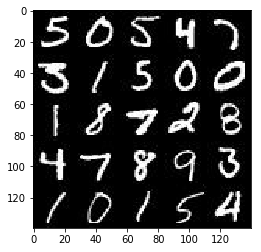

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

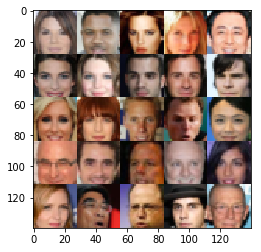

In [35]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function - DONE
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(),name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
#passing in 28*28*3 images to the discriminator
#returns output (Real or fake) and also, logits which are used to calculate cross entropy loss

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        ## 28x28x3
        layer_1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        # 14x14x64
        
        layer_2 = tf.layers.conv2d(layer_1, filters=128, kernel_size=4 , strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        # 7x7x128
        
        layer_3 = tf.layers.conv2d(layer_2, filters=256, kernel_size=4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
        #4x4x256
        
        flattened = tf.reshape(layer_3, (-1, 4*4*256))
        #4096
        
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        
        layer_0 = tf.layers.dense(z, 4*4*1024)
        layer_0 = tf.reshape(layer_0, (-1, 4, 4, 1024))
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train)
        layer_0 = tf.maximum(0.1 * layer_0, layer_0)
        layer_0 = tf.nn.dropout(layer_0, 0.5)
        
        layer_1 = tf.layers.conv2d_transpose(layer_0, 512, 4, 1, 'valid', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        layer_1 = tf.nn.dropout(layer_1, 0.5)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, 2, 'same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        layer_2 = tf.nn.dropout(layer_2, 0.5)

        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, 2, 'same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
        layer_3 = tf.nn.dropout(layer_3, 0.5)
       
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, 1, 'same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_real)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{};".format(epoch_i + 1, epochs), "Discriminator Loss: {:.4f};".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4; Discriminator Loss: 1.4937; Generator Loss: 1.0404
Epoch 1/4; Discriminator Loss: 1.8596; Generator Loss: 1.9847
Epoch 1/4; Discriminator Loss: 1.1115; Generator Loss: 0.8773
Epoch 1/4; Discriminator Loss: 1.6573; Generator Loss: 3.3922
Epoch 1/4; Discriminator Loss: 0.9640; Generator Loss: 1.4873
Epoch 1/4; Discriminator Loss: 0.7518; Generator Loss: 1.4117
Epoch 1/4; Discriminator Loss: 0.8428; Generator Loss: 1.8852
Epoch 1/4; Discriminator Loss: 0.3999; Generator Loss: 3.4533
Epoch 1/4; Discriminator Loss: 0.6685; Generator Loss: 2.0798
Epoch 1/4; Discriminator Loss: 0.9862; Generator Loss: 1.5288


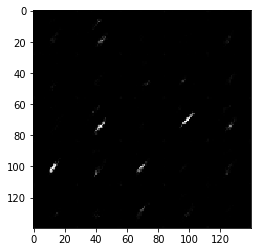

Epoch 1/4; Discriminator Loss: 0.9569; Generator Loss: 1.6236
Epoch 1/4; Discriminator Loss: 0.5010; Generator Loss: 2.5498
Epoch 1/4; Discriminator Loss: 0.9621; Generator Loss: 1.5828
Epoch 1/4; Discriminator Loss: 1.0693; Generator Loss: 1.4275
Epoch 1/4; Discriminator Loss: 0.7345; Generator Loss: 2.0004
Epoch 1/4; Discriminator Loss: 1.0269; Generator Loss: 1.2070
Epoch 1/4; Discriminator Loss: 0.8124; Generator Loss: 1.6733
Epoch 1/4; Discriminator Loss: 0.7701; Generator Loss: 1.7718
Epoch 1/4; Discriminator Loss: 1.2828; Generator Loss: 1.5872
Epoch 1/4; Discriminator Loss: 1.2631; Generator Loss: 0.7385


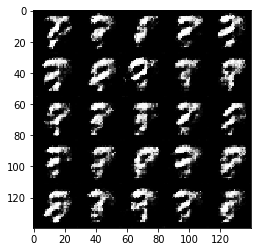

Epoch 1/4; Discriminator Loss: 1.1564; Generator Loss: 1.0864
Epoch 1/4; Discriminator Loss: 1.2825; Generator Loss: 1.0161
Epoch 1/4; Discriminator Loss: 0.9401; Generator Loss: 1.5721
Epoch 1/4; Discriminator Loss: 0.9933; Generator Loss: 1.1904
Epoch 1/4; Discriminator Loss: 0.9039; Generator Loss: 1.2942
Epoch 1/4; Discriminator Loss: 1.1689; Generator Loss: 0.7814
Epoch 1/4; Discriminator Loss: 1.0244; Generator Loss: 1.0560
Epoch 1/4; Discriminator Loss: 1.0489; Generator Loss: 1.4023
Epoch 1/4; Discriminator Loss: 1.2870; Generator Loss: 0.7617
Epoch 1/4; Discriminator Loss: 1.4072; Generator Loss: 1.3540


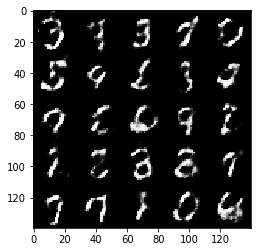

Epoch 1/4; Discriminator Loss: 1.1761; Generator Loss: 1.0864
Epoch 1/4; Discriminator Loss: 1.2470; Generator Loss: 1.5572
Epoch 1/4; Discriminator Loss: 1.1820; Generator Loss: 0.8651
Epoch 1/4; Discriminator Loss: 1.2942; Generator Loss: 0.7289
Epoch 1/4; Discriminator Loss: 1.1196; Generator Loss: 1.2870
Epoch 1/4; Discriminator Loss: 1.1116; Generator Loss: 0.9903
Epoch 1/4; Discriminator Loss: 1.1086; Generator Loss: 0.9231
Epoch 1/4; Discriminator Loss: 1.1143; Generator Loss: 1.2086
Epoch 1/4; Discriminator Loss: 1.2084; Generator Loss: 0.8860
Epoch 1/4; Discriminator Loss: 1.2471; Generator Loss: 1.4800


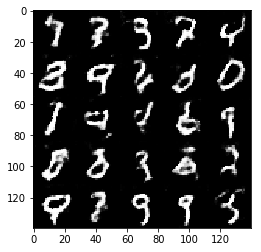

Epoch 1/4; Discriminator Loss: 1.2639; Generator Loss: 1.8176
Epoch 1/4; Discriminator Loss: 1.1971; Generator Loss: 0.8094
Epoch 1/4; Discriminator Loss: 1.0875; Generator Loss: 1.2159
Epoch 1/4; Discriminator Loss: 1.2088; Generator Loss: 0.6722
Epoch 1/4; Discriminator Loss: 1.1504; Generator Loss: 0.8166
Epoch 1/4; Discriminator Loss: 1.0694; Generator Loss: 1.0522
Epoch 2/4; Discriminator Loss: 1.2479; Generator Loss: 1.6197
Epoch 2/4; Discriminator Loss: 1.0700; Generator Loss: 1.3962
Epoch 2/4; Discriminator Loss: 1.1124; Generator Loss: 1.4122
Epoch 2/4; Discriminator Loss: 1.1815; Generator Loss: 1.1082


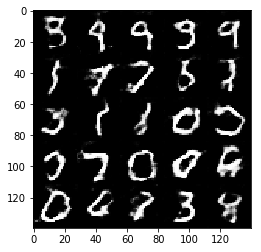

Epoch 2/4; Discriminator Loss: 1.1098; Generator Loss: 1.1189
Epoch 2/4; Discriminator Loss: 1.1272; Generator Loss: 0.9892
Epoch 2/4; Discriminator Loss: 1.1550; Generator Loss: 0.9866
Epoch 2/4; Discriminator Loss: 1.1286; Generator Loss: 0.8113
Epoch 2/4; Discriminator Loss: 1.1146; Generator Loss: 0.8113
Epoch 2/4; Discriminator Loss: 1.2066; Generator Loss: 0.7070
Epoch 2/4; Discriminator Loss: 1.1893; Generator Loss: 1.5573
Epoch 2/4; Discriminator Loss: 1.0324; Generator Loss: 1.2750
Epoch 2/4; Discriminator Loss: 1.0941; Generator Loss: 1.4846
Epoch 2/4; Discriminator Loss: 1.0079; Generator Loss: 0.9153


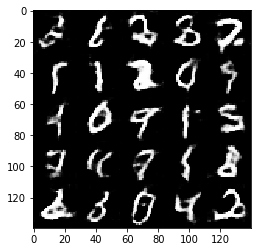

Epoch 2/4; Discriminator Loss: 1.1075; Generator Loss: 1.3884
Epoch 2/4; Discriminator Loss: 1.1400; Generator Loss: 1.6619
Epoch 2/4; Discriminator Loss: 1.0975; Generator Loss: 0.8991
Epoch 2/4; Discriminator Loss: 1.1993; Generator Loss: 1.7753
Epoch 2/4; Discriminator Loss: 1.0224; Generator Loss: 1.0101
Epoch 2/4; Discriminator Loss: 1.0564; Generator Loss: 1.1046
Epoch 2/4; Discriminator Loss: 1.1058; Generator Loss: 1.5565
Epoch 2/4; Discriminator Loss: 1.0756; Generator Loss: 1.4116
Epoch 2/4; Discriminator Loss: 1.0349; Generator Loss: 1.5269
Epoch 2/4; Discriminator Loss: 1.0406; Generator Loss: 1.3431


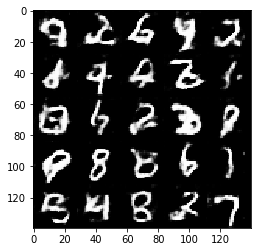

Epoch 2/4; Discriminator Loss: 1.0869; Generator Loss: 1.2704
Epoch 2/4; Discriminator Loss: 1.0664; Generator Loss: 0.9141
Epoch 2/4; Discriminator Loss: 1.0907; Generator Loss: 0.8711
Epoch 2/4; Discriminator Loss: 1.0335; Generator Loss: 1.0708
Epoch 2/4; Discriminator Loss: 1.0688; Generator Loss: 1.0591
Epoch 2/4; Discriminator Loss: 1.1247; Generator Loss: 0.8063
Epoch 2/4; Discriminator Loss: 1.0666; Generator Loss: 0.9093
Epoch 2/4; Discriminator Loss: 0.9616; Generator Loss: 1.1422
Epoch 2/4; Discriminator Loss: 1.4343; Generator Loss: 2.4549
Epoch 2/4; Discriminator Loss: 1.0875; Generator Loss: 0.8716


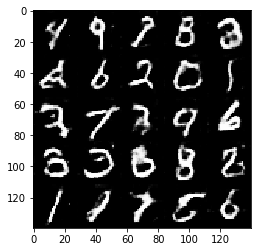

Epoch 2/4; Discriminator Loss: 1.0264; Generator Loss: 0.9223
Epoch 2/4; Discriminator Loss: 0.9039; Generator Loss: 1.4515
Epoch 2/4; Discriminator Loss: 1.0355; Generator Loss: 0.9118
Epoch 2/4; Discriminator Loss: 0.9840; Generator Loss: 1.5445
Epoch 2/4; Discriminator Loss: 0.9583; Generator Loss: 1.0967
Epoch 2/4; Discriminator Loss: 0.9917; Generator Loss: 1.4945
Epoch 2/4; Discriminator Loss: 1.3169; Generator Loss: 1.9172
Epoch 2/4; Discriminator Loss: 0.9150; Generator Loss: 1.5061
Epoch 2/4; Discriminator Loss: 1.1373; Generator Loss: 0.7185
Epoch 2/4; Discriminator Loss: 1.0467; Generator Loss: 1.6594


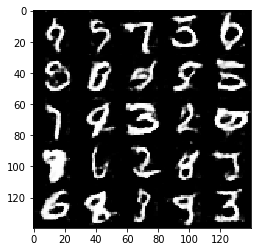

Epoch 2/4; Discriminator Loss: 0.9771; Generator Loss: 1.1967
Epoch 2/4; Discriminator Loss: 0.9819; Generator Loss: 1.0815
Epoch 2/4; Discriminator Loss: 0.9751; Generator Loss: 1.3333
Epoch 3/4; Discriminator Loss: 1.4480; Generator Loss: 1.8287
Epoch 3/4; Discriminator Loss: 0.9942; Generator Loss: 1.4059
Epoch 3/4; Discriminator Loss: 1.0313; Generator Loss: 1.6729
Epoch 3/4; Discriminator Loss: 0.9262; Generator Loss: 1.3742
Epoch 3/4; Discriminator Loss: 0.9959; Generator Loss: 0.9624
Epoch 3/4; Discriminator Loss: 1.0954; Generator Loss: 0.7956
Epoch 3/4; Discriminator Loss: 0.9499; Generator Loss: 1.3418


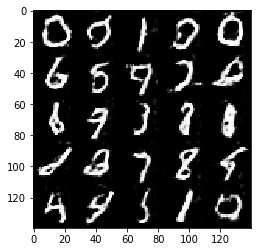

Epoch 3/4; Discriminator Loss: 1.1084; Generator Loss: 0.7616
Epoch 3/4; Discriminator Loss: 1.1078; Generator Loss: 1.4080
Epoch 3/4; Discriminator Loss: 0.9878; Generator Loss: 0.9729
Epoch 3/4; Discriminator Loss: 0.9345; Generator Loss: 1.1869
Epoch 3/4; Discriminator Loss: 1.0858; Generator Loss: 0.8180
Epoch 3/4; Discriminator Loss: 1.0727; Generator Loss: 1.4771
Epoch 3/4; Discriminator Loss: 0.9780; Generator Loss: 0.9770
Epoch 3/4; Discriminator Loss: 1.0165; Generator Loss: 1.6735
Epoch 3/4; Discriminator Loss: 1.0112; Generator Loss: 1.6377
Epoch 3/4; Discriminator Loss: 0.9765; Generator Loss: 1.8660


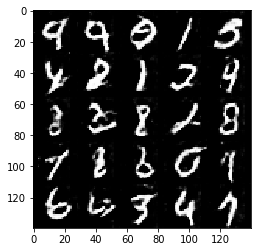

Epoch 3/4; Discriminator Loss: 1.0021; Generator Loss: 1.1305
Epoch 3/4; Discriminator Loss: 0.9383; Generator Loss: 1.0686
Epoch 3/4; Discriminator Loss: 0.9556; Generator Loss: 1.5136
Epoch 3/4; Discriminator Loss: 0.9093; Generator Loss: 1.3340
Epoch 3/4; Discriminator Loss: 1.1217; Generator Loss: 1.9375
Epoch 3/4; Discriminator Loss: 0.9606; Generator Loss: 0.9763
Epoch 3/4; Discriminator Loss: 0.9846; Generator Loss: 1.0468
Epoch 3/4; Discriminator Loss: 1.0713; Generator Loss: 0.7647
Epoch 3/4; Discriminator Loss: 0.9117; Generator Loss: 1.5239
Epoch 3/4; Discriminator Loss: 0.8911; Generator Loss: 1.4935


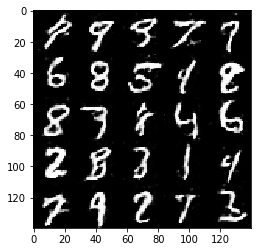

Epoch 3/4; Discriminator Loss: 0.9621; Generator Loss: 1.3214
Epoch 3/4; Discriminator Loss: 0.9943; Generator Loss: 1.0150
Epoch 3/4; Discriminator Loss: 0.9820; Generator Loss: 0.9877
Epoch 3/4; Discriminator Loss: 0.9679; Generator Loss: 0.8702
Epoch 3/4; Discriminator Loss: 0.8613; Generator Loss: 1.5512
Epoch 3/4; Discriminator Loss: 0.9913; Generator Loss: 1.7720
Epoch 3/4; Discriminator Loss: 1.0400; Generator Loss: 0.8714
Epoch 3/4; Discriminator Loss: 1.0591; Generator Loss: 1.3468
Epoch 3/4; Discriminator Loss: 0.9268; Generator Loss: 1.7948
Epoch 3/4; Discriminator Loss: 0.8847; Generator Loss: 1.1742


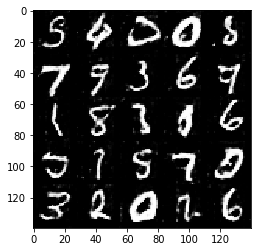

Epoch 3/4; Discriminator Loss: 0.8411; Generator Loss: 1.5657
Epoch 3/4; Discriminator Loss: 1.1112; Generator Loss: 1.7133
Epoch 3/4; Discriminator Loss: 0.9968; Generator Loss: 1.0166
Epoch 3/4; Discriminator Loss: 1.1656; Generator Loss: 1.9355
Epoch 3/4; Discriminator Loss: 0.8522; Generator Loss: 1.7074
Epoch 3/4; Discriminator Loss: 1.0054; Generator Loss: 0.9487
Epoch 3/4; Discriminator Loss: 1.0657; Generator Loss: 0.8640
Epoch 3/4; Discriminator Loss: 0.8961; Generator Loss: 1.1630
Epoch 3/4; Discriminator Loss: 1.0380; Generator Loss: 2.0990
Epoch 3/4; Discriminator Loss: 0.9476; Generator Loss: 1.0512


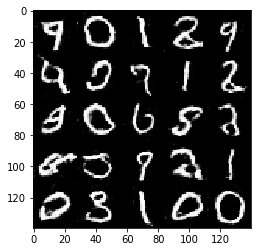

Epoch 4/4; Discriminator Loss: 0.8568; Generator Loss: 1.5586
Epoch 4/4; Discriminator Loss: 0.8186; Generator Loss: 1.3995
Epoch 4/4; Discriminator Loss: 0.8949; Generator Loss: 1.4670
Epoch 4/4; Discriminator Loss: 0.8937; Generator Loss: 1.3572
Epoch 4/4; Discriminator Loss: 0.9848; Generator Loss: 1.9361
Epoch 4/4; Discriminator Loss: 0.9180; Generator Loss: 1.0234
Epoch 4/4; Discriminator Loss: 1.2365; Generator Loss: 0.5699
Epoch 4/4; Discriminator Loss: 1.1842; Generator Loss: 1.1519
Epoch 4/4; Discriminator Loss: 0.9610; Generator Loss: 1.3576
Epoch 4/4; Discriminator Loss: 0.8917; Generator Loss: 1.4621


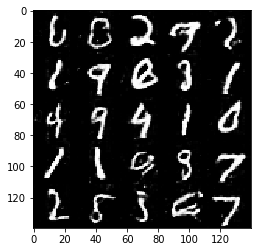

Epoch 4/4; Discriminator Loss: 0.8843; Generator Loss: 1.3128
Epoch 4/4; Discriminator Loss: 0.9027; Generator Loss: 1.5087
Epoch 4/4; Discriminator Loss: 0.8963; Generator Loss: 1.3574
Epoch 4/4; Discriminator Loss: 0.8147; Generator Loss: 1.4509
Epoch 4/4; Discriminator Loss: 1.1173; Generator Loss: 2.3758
Epoch 4/4; Discriminator Loss: 0.9270; Generator Loss: 1.0837
Epoch 4/4; Discriminator Loss: 0.8625; Generator Loss: 1.7514
Epoch 4/4; Discriminator Loss: 0.8787; Generator Loss: 1.2442
Epoch 4/4; Discriminator Loss: 0.8411; Generator Loss: 1.2835
Epoch 4/4; Discriminator Loss: 1.7422; Generator Loss: 2.5565


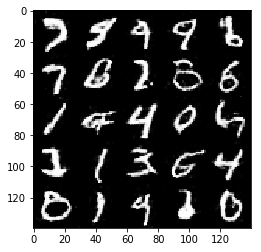

Epoch 4/4; Discriminator Loss: 0.8626; Generator Loss: 1.2145
Epoch 4/4; Discriminator Loss: 0.8615; Generator Loss: 1.4108
Epoch 4/4; Discriminator Loss: 0.9246; Generator Loss: 1.3420
Epoch 4/4; Discriminator Loss: 0.8929; Generator Loss: 1.8095
Epoch 4/4; Discriminator Loss: 1.0709; Generator Loss: 0.9451
Epoch 4/4; Discriminator Loss: 0.8532; Generator Loss: 1.3275
Epoch 4/4; Discriminator Loss: 0.7939; Generator Loss: 1.3062
Epoch 4/4; Discriminator Loss: 0.9126; Generator Loss: 1.0718
Epoch 4/4; Discriminator Loss: 0.8755; Generator Loss: 1.6056
Epoch 4/4; Discriminator Loss: 0.8701; Generator Loss: 1.1538


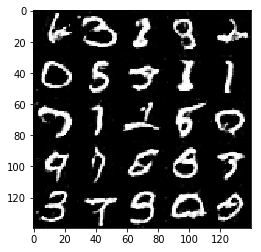

Epoch 4/4; Discriminator Loss: 2.0020; Generator Loss: 0.2523
Epoch 4/4; Discriminator Loss: 0.9014; Generator Loss: 1.3687
Epoch 4/4; Discriminator Loss: 0.8608; Generator Loss: 1.3445
Epoch 4/4; Discriminator Loss: 0.8960; Generator Loss: 1.5900
Epoch 4/4; Discriminator Loss: 0.9053; Generator Loss: 1.6395
Epoch 4/4; Discriminator Loss: 0.8337; Generator Loss: 1.6678
Epoch 4/4; Discriminator Loss: 0.9017; Generator Loss: 1.4949
Epoch 4/4; Discriminator Loss: 0.8375; Generator Loss: 1.2251
Epoch 4/4; Discriminator Loss: 0.8923; Generator Loss: 2.1315
Epoch 4/4; Discriminator Loss: 0.8168; Generator Loss: 1.3233


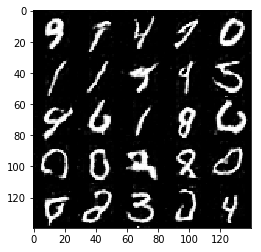

Epoch 4/4; Discriminator Loss: 0.9714; Generator Loss: 0.8939
Epoch 4/4; Discriminator Loss: 0.8881; Generator Loss: 1.1857
Epoch 4/4; Discriminator Loss: 0.8111; Generator Loss: 1.7336
Epoch 4/4; Discriminator Loss: 0.8820; Generator Loss: 1.1384
Epoch 4/4; Discriminator Loss: 0.8214; Generator Loss: 1.8685
Epoch 4/4; Discriminator Loss: 0.7604; Generator Loss: 1.7881
Epoch 4/4; Discriminator Loss: 0.7148; Generator Loss: 2.0640


In [45]:
# batch_size  = 100
# z_dim = 100
# learning_rate = 0.001
# beta1 = 0.5
batch_size  = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2; Discriminator Loss: 0.8457; Generator Loss: 1.5835
Epoch 1/2; Discriminator Loss: 1.1107; Generator Loss: 1.5013
Epoch 1/2; Discriminator Loss: 0.5809; Generator Loss: 2.5876
Epoch 1/2; Discriminator Loss: 1.2865; Generator Loss: 0.7261
Epoch 1/2; Discriminator Loss: 0.7461; Generator Loss: 1.5999
Epoch 1/2; Discriminator Loss: 0.5963; Generator Loss: 2.0850
Epoch 1/2; Discriminator Loss: 0.7578; Generator Loss: 1.8317
Epoch 1/2; Discriminator Loss: 0.6127; Generator Loss: 2.0399
Epoch 1/2; Discriminator Loss: 0.9220; Generator Loss: 0.9717
Epoch 1/2; Discriminator Loss: 0.5463; Generator Loss: 2.8094


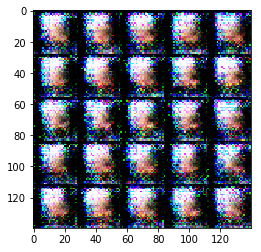

Epoch 1/2; Discriminator Loss: 0.4546; Generator Loss: 3.2728
Epoch 1/2; Discriminator Loss: 0.4765; Generator Loss: 2.9385
Epoch 1/2; Discriminator Loss: 0.5195; Generator Loss: 4.5989
Epoch 1/2; Discriminator Loss: 0.6826; Generator Loss: 1.4509
Epoch 1/2; Discriminator Loss: 0.5156; Generator Loss: 2.7976
Epoch 1/2; Discriminator Loss: 0.4218; Generator Loss: 3.7958
Epoch 1/2; Discriminator Loss: 0.3914; Generator Loss: 3.7807
Epoch 1/2; Discriminator Loss: 0.4119; Generator Loss: 3.3132
Epoch 1/2; Discriminator Loss: 0.4773; Generator Loss: 2.3805
Epoch 1/2; Discriminator Loss: 0.4933; Generator Loss: 2.5534


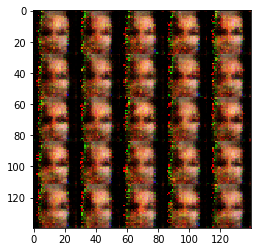

Epoch 1/2; Discriminator Loss: 0.5897; Generator Loss: 2.0481
Epoch 1/2; Discriminator Loss: 0.4540; Generator Loss: 2.9759
Epoch 1/2; Discriminator Loss: 0.4800; Generator Loss: 2.7312
Epoch 1/2; Discriminator Loss: 0.4871; Generator Loss: 2.7416
Epoch 1/2; Discriminator Loss: 0.4451; Generator Loss: 3.4073
Epoch 1/2; Discriminator Loss: 0.4847; Generator Loss: 2.7112
Epoch 1/2; Discriminator Loss: 0.4064; Generator Loss: 3.5939
Epoch 1/2; Discriminator Loss: 0.3992; Generator Loss: 3.5980
Epoch 1/2; Discriminator Loss: 0.3923; Generator Loss: 3.7316
Epoch 1/2; Discriminator Loss: 0.4025; Generator Loss: 3.6733


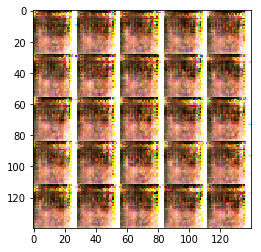

Epoch 1/2; Discriminator Loss: 0.3740; Generator Loss: 4.0669
Epoch 1/2; Discriminator Loss: 0.3725; Generator Loss: 3.8994
Epoch 1/2; Discriminator Loss: 0.3775; Generator Loss: 3.7160
Epoch 1/2; Discriminator Loss: 0.8136; Generator Loss: 1.4365
Epoch 1/2; Discriminator Loss: 0.7857; Generator Loss: 1.2706
Epoch 1/2; Discriminator Loss: 0.7061; Generator Loss: 2.0586
Epoch 1/2; Discriminator Loss: 1.0407; Generator Loss: 0.9891
Epoch 1/2; Discriminator Loss: 0.7389; Generator Loss: 1.3557
Epoch 1/2; Discriminator Loss: 0.7576; Generator Loss: 1.3857
Epoch 1/2; Discriminator Loss: 0.7067; Generator Loss: 1.7509


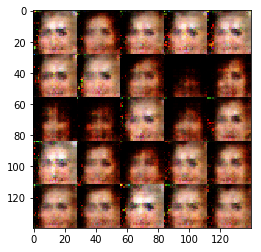

Epoch 1/2; Discriminator Loss: 0.6158; Generator Loss: 1.8696
Epoch 1/2; Discriminator Loss: 1.3889; Generator Loss: 0.5480
Epoch 1/2; Discriminator Loss: 2.0722; Generator Loss: 2.9240
Epoch 1/2; Discriminator Loss: 1.1219; Generator Loss: 1.0389
Epoch 1/2; Discriminator Loss: 0.9341; Generator Loss: 1.8442
Epoch 1/2; Discriminator Loss: 1.3101; Generator Loss: 1.5248
Epoch 1/2; Discriminator Loss: 1.3301; Generator Loss: 1.0946
Epoch 1/2; Discriminator Loss: 1.1833; Generator Loss: 0.9039
Epoch 1/2; Discriminator Loss: 1.0583; Generator Loss: 1.1218
Epoch 1/2; Discriminator Loss: 0.9464; Generator Loss: 1.3464


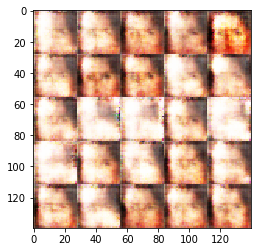

Epoch 1/2; Discriminator Loss: 0.9638; Generator Loss: 1.3880
Epoch 1/2; Discriminator Loss: 0.9639; Generator Loss: 1.1555
Epoch 1/2; Discriminator Loss: 1.1421; Generator Loss: 1.1443
Epoch 1/2; Discriminator Loss: 1.3679; Generator Loss: 0.8764
Epoch 1/2; Discriminator Loss: 1.1441; Generator Loss: 0.7761
Epoch 1/2; Discriminator Loss: 1.2220; Generator Loss: 1.0467
Epoch 1/2; Discriminator Loss: 1.2869; Generator Loss: 0.8818
Epoch 1/2; Discriminator Loss: 1.0221; Generator Loss: 1.3715
Epoch 1/2; Discriminator Loss: 1.1947; Generator Loss: 1.3543
Epoch 1/2; Discriminator Loss: 1.4457; Generator Loss: 1.0086


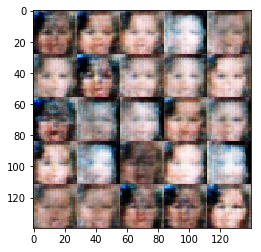

Epoch 1/2; Discriminator Loss: 1.6845; Generator Loss: 0.7525
Epoch 1/2; Discriminator Loss: 1.0910; Generator Loss: 1.2491
Epoch 1/2; Discriminator Loss: 1.3601; Generator Loss: 0.7566
Epoch 1/2; Discriminator Loss: 1.2032; Generator Loss: 1.2130
Epoch 1/2; Discriminator Loss: 1.4725; Generator Loss: 0.8163
Epoch 1/2; Discriminator Loss: 1.3675; Generator Loss: 0.9366
Epoch 1/2; Discriminator Loss: 1.3080; Generator Loss: 0.9374
Epoch 1/2; Discriminator Loss: 1.4111; Generator Loss: 0.8782
Epoch 1/2; Discriminator Loss: 1.3632; Generator Loss: 0.9446
Epoch 1/2; Discriminator Loss: 1.3023; Generator Loss: 0.9147


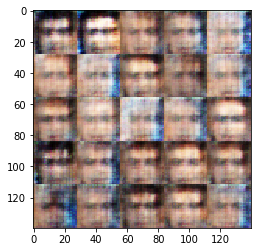

Epoch 1/2; Discriminator Loss: 1.3116; Generator Loss: 1.0724
Epoch 1/2; Discriminator Loss: 1.4006; Generator Loss: 0.9700
Epoch 1/2; Discriminator Loss: 1.2835; Generator Loss: 1.1371
Epoch 1/2; Discriminator Loss: 1.3014; Generator Loss: 0.9070
Epoch 1/2; Discriminator Loss: 1.4174; Generator Loss: 0.8634
Epoch 1/2; Discriminator Loss: 1.3475; Generator Loss: 0.9641
Epoch 1/2; Discriminator Loss: 1.2126; Generator Loss: 1.1095
Epoch 1/2; Discriminator Loss: 1.4103; Generator Loss: 0.9602
Epoch 1/2; Discriminator Loss: 1.4495; Generator Loss: 0.9079
Epoch 1/2; Discriminator Loss: 1.2498; Generator Loss: 1.0928


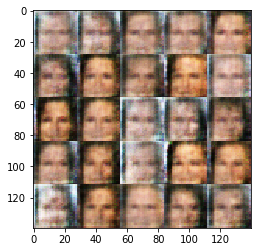

Epoch 1/2; Discriminator Loss: 1.2879; Generator Loss: 0.9114
Epoch 1/2; Discriminator Loss: 1.1509; Generator Loss: 1.1091
Epoch 1/2; Discriminator Loss: 1.3912; Generator Loss: 0.8747
Epoch 1/2; Discriminator Loss: 1.3586; Generator Loss: 0.9272
Epoch 1/2; Discriminator Loss: 1.1248; Generator Loss: 1.1086
Epoch 1/2; Discriminator Loss: 1.4101; Generator Loss: 0.8062
Epoch 1/2; Discriminator Loss: 1.1313; Generator Loss: 1.1375
Epoch 1/2; Discriminator Loss: 1.2394; Generator Loss: 1.0328
Epoch 1/2; Discriminator Loss: 1.4402; Generator Loss: 0.8518
Epoch 1/2; Discriminator Loss: 1.3489; Generator Loss: 0.8315


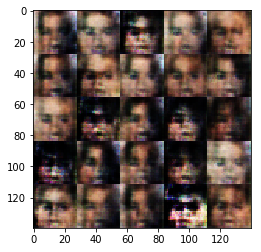

Epoch 1/2; Discriminator Loss: 1.2889; Generator Loss: 1.0098
Epoch 1/2; Discriminator Loss: 1.3154; Generator Loss: 0.8496
Epoch 1/2; Discriminator Loss: 1.2394; Generator Loss: 0.9076
Epoch 1/2; Discriminator Loss: 1.1850; Generator Loss: 1.0217
Epoch 1/2; Discriminator Loss: 1.2490; Generator Loss: 0.8881
Epoch 1/2; Discriminator Loss: 1.2830; Generator Loss: 0.9489
Epoch 1/2; Discriminator Loss: 1.5162; Generator Loss: 0.8955
Epoch 1/2; Discriminator Loss: 1.4671; Generator Loss: 0.9597
Epoch 1/2; Discriminator Loss: 1.5561; Generator Loss: 0.7718
Epoch 1/2; Discriminator Loss: 1.2686; Generator Loss: 0.9984


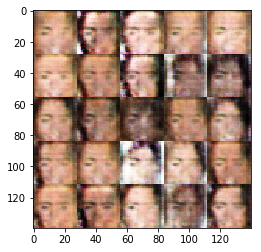

Epoch 1/2; Discriminator Loss: 1.1898; Generator Loss: 1.1471
Epoch 1/2; Discriminator Loss: 1.1705; Generator Loss: 0.9946
Epoch 1/2; Discriminator Loss: 1.1187; Generator Loss: 1.1837
Epoch 1/2; Discriminator Loss: 1.2004; Generator Loss: 1.2029
Epoch 1/2; Discriminator Loss: 1.3225; Generator Loss: 0.9940
Epoch 1/2; Discriminator Loss: 1.1186; Generator Loss: 1.0799
Epoch 1/2; Discriminator Loss: 1.3967; Generator Loss: 0.9729
Epoch 1/2; Discriminator Loss: 1.2823; Generator Loss: 0.9454
Epoch 1/2; Discriminator Loss: 1.3254; Generator Loss: 0.8641
Epoch 1/2; Discriminator Loss: 1.3386; Generator Loss: 1.0443


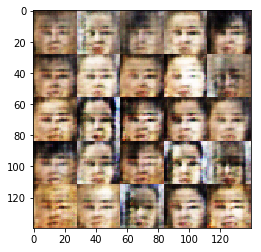

Epoch 1/2; Discriminator Loss: 1.3044; Generator Loss: 0.9633
Epoch 1/2; Discriminator Loss: 1.1652; Generator Loss: 1.0825
Epoch 1/2; Discriminator Loss: 1.3270; Generator Loss: 0.8426
Epoch 1/2; Discriminator Loss: 1.1429; Generator Loss: 1.0941
Epoch 1/2; Discriminator Loss: 1.2463; Generator Loss: 1.1167
Epoch 1/2; Discriminator Loss: 1.1161; Generator Loss: 1.0348
Epoch 1/2; Discriminator Loss: 1.2559; Generator Loss: 0.9764
Epoch 1/2; Discriminator Loss: 1.2729; Generator Loss: 0.9133
Epoch 1/2; Discriminator Loss: 1.4140; Generator Loss: 0.8543
Epoch 1/2; Discriminator Loss: 1.4196; Generator Loss: 0.9330


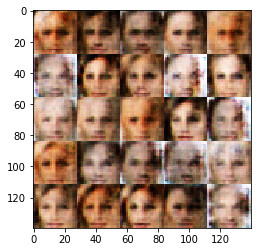

Epoch 1/2; Discriminator Loss: 1.2924; Generator Loss: 0.9973
Epoch 1/2; Discriminator Loss: 1.6464; Generator Loss: 0.6458
Epoch 1/2; Discriminator Loss: 1.3022; Generator Loss: 1.0186
Epoch 1/2; Discriminator Loss: 1.3903; Generator Loss: 0.8647
Epoch 1/2; Discriminator Loss: 1.3690; Generator Loss: 0.8602
Epoch 1/2; Discriminator Loss: 1.2442; Generator Loss: 0.9507
Epoch 1/2; Discriminator Loss: 1.2853; Generator Loss: 0.9531
Epoch 1/2; Discriminator Loss: 1.1689; Generator Loss: 1.1109
Epoch 1/2; Discriminator Loss: 1.2907; Generator Loss: 0.9416
Epoch 1/2; Discriminator Loss: 1.1515; Generator Loss: 1.1211


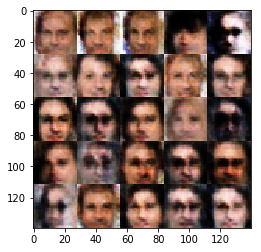

Epoch 1/2; Discriminator Loss: 1.1161; Generator Loss: 1.1350
Epoch 1/2; Discriminator Loss: 1.2030; Generator Loss: 1.0514
Epoch 1/2; Discriminator Loss: 1.3746; Generator Loss: 0.8787
Epoch 1/2; Discriminator Loss: 1.4033; Generator Loss: 0.9252
Epoch 1/2; Discriminator Loss: 1.3203; Generator Loss: 0.9742
Epoch 1/2; Discriminator Loss: 1.4274; Generator Loss: 0.7765
Epoch 1/2; Discriminator Loss: 1.3402; Generator Loss: 0.8854
Epoch 1/2; Discriminator Loss: 1.3190; Generator Loss: 0.9842
Epoch 1/2; Discriminator Loss: 1.3058; Generator Loss: 1.0386
Epoch 1/2; Discriminator Loss: 1.1967; Generator Loss: 0.9813


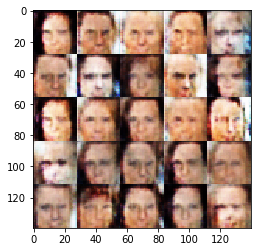

Epoch 1/2; Discriminator Loss: 1.2531; Generator Loss: 0.8963
Epoch 1/2; Discriminator Loss: 1.4524; Generator Loss: 0.7743
Epoch 1/2; Discriminator Loss: 1.3440; Generator Loss: 0.9552
Epoch 1/2; Discriminator Loss: 1.2829; Generator Loss: 1.0109
Epoch 1/2; Discriminator Loss: 1.2775; Generator Loss: 0.9824
Epoch 1/2; Discriminator Loss: 1.3797; Generator Loss: 0.8534
Epoch 1/2; Discriminator Loss: 1.4639; Generator Loss: 0.8430
Epoch 1/2; Discriminator Loss: 1.2217; Generator Loss: 0.9736
Epoch 1/2; Discriminator Loss: 1.3508; Generator Loss: 0.8879
Epoch 1/2; Discriminator Loss: 1.4447; Generator Loss: 0.9074


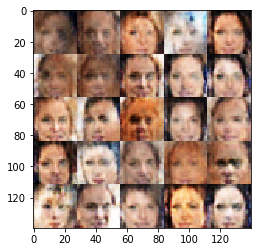

Epoch 1/2; Discriminator Loss: 1.2602; Generator Loss: 0.9657
Epoch 1/2; Discriminator Loss: 1.3683; Generator Loss: 0.8964
Epoch 1/2; Discriminator Loss: 1.3495; Generator Loss: 0.9686
Epoch 1/2; Discriminator Loss: 1.2215; Generator Loss: 0.9431
Epoch 1/2; Discriminator Loss: 1.2744; Generator Loss: 0.8592
Epoch 1/2; Discriminator Loss: 1.2629; Generator Loss: 0.9172
Epoch 1/2; Discriminator Loss: 1.1920; Generator Loss: 0.9380
Epoch 1/2; Discriminator Loss: 1.3758; Generator Loss: 0.7834
Epoch 2/2; Discriminator Loss: 1.4327; Generator Loss: 0.8449
Epoch 2/2; Discriminator Loss: 1.2937; Generator Loss: 1.0089


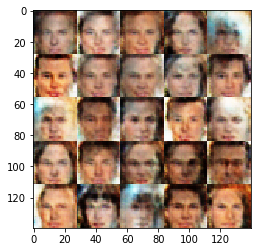

Epoch 2/2; Discriminator Loss: 1.3130; Generator Loss: 0.9876
Epoch 2/2; Discriminator Loss: 1.4037; Generator Loss: 0.8571
Epoch 2/2; Discriminator Loss: 1.5958; Generator Loss: 0.6914
Epoch 2/2; Discriminator Loss: 1.3473; Generator Loss: 0.7325
Epoch 2/2; Discriminator Loss: 1.2606; Generator Loss: 0.9200
Epoch 2/2; Discriminator Loss: 1.3091; Generator Loss: 0.9305
Epoch 2/2; Discriminator Loss: 1.3880; Generator Loss: 0.7919
Epoch 2/2; Discriminator Loss: 1.3565; Generator Loss: 0.7428
Epoch 2/2; Discriminator Loss: 1.4498; Generator Loss: 0.8507
Epoch 2/2; Discriminator Loss: 1.4326; Generator Loss: 0.6635


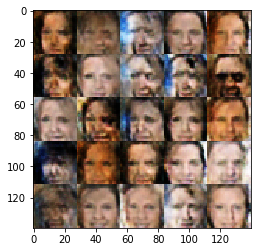

Epoch 2/2; Discriminator Loss: 1.4190; Generator Loss: 0.7283
Epoch 2/2; Discriminator Loss: 1.2895; Generator Loss: 0.8829
Epoch 2/2; Discriminator Loss: 1.2497; Generator Loss: 1.0412
Epoch 2/2; Discriminator Loss: 1.5219; Generator Loss: 0.6574
Epoch 2/2; Discriminator Loss: 1.4032; Generator Loss: 0.7119
Epoch 2/2; Discriminator Loss: 1.3750; Generator Loss: 0.8366
Epoch 2/2; Discriminator Loss: 1.2075; Generator Loss: 1.0017
Epoch 2/2; Discriminator Loss: 1.3661; Generator Loss: 0.7932
Epoch 2/2; Discriminator Loss: 1.4094; Generator Loss: 0.8010
Epoch 2/2; Discriminator Loss: 1.2519; Generator Loss: 0.9916


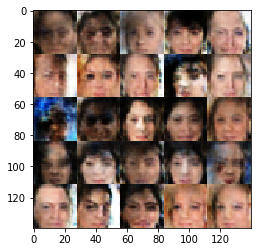

Epoch 2/2; Discriminator Loss: 1.3756; Generator Loss: 0.8410
Epoch 2/2; Discriminator Loss: 1.2459; Generator Loss: 0.9337
Epoch 2/2; Discriminator Loss: 1.7220; Generator Loss: 0.6235
Epoch 2/2; Discriminator Loss: 1.6641; Generator Loss: 0.8554
Epoch 2/2; Discriminator Loss: 1.3458; Generator Loss: 0.9242
Epoch 2/2; Discriminator Loss: 1.2649; Generator Loss: 0.9740
Epoch 2/2; Discriminator Loss: 1.2858; Generator Loss: 0.8326
Epoch 2/2; Discriminator Loss: 1.2023; Generator Loss: 0.9370
Epoch 2/2; Discriminator Loss: 1.1832; Generator Loss: 1.0049
Epoch 2/2; Discriminator Loss: 1.5240; Generator Loss: 0.8338


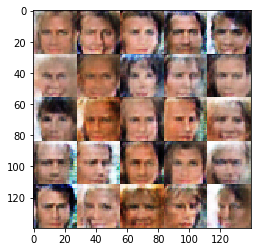

Epoch 2/2; Discriminator Loss: 1.3924; Generator Loss: 0.7894
Epoch 2/2; Discriminator Loss: 1.3539; Generator Loss: 0.8541
Epoch 2/2; Discriminator Loss: 1.4404; Generator Loss: 0.7595
Epoch 2/2; Discriminator Loss: 1.3204; Generator Loss: 0.8617
Epoch 2/2; Discriminator Loss: 1.5012; Generator Loss: 0.7780
Epoch 2/2; Discriminator Loss: 1.2597; Generator Loss: 0.7985
Epoch 2/2; Discriminator Loss: 1.4044; Generator Loss: 0.8470
Epoch 2/2; Discriminator Loss: 1.4013; Generator Loss: 0.7892
Epoch 2/2; Discriminator Loss: 1.2233; Generator Loss: 0.9663
Epoch 2/2; Discriminator Loss: 1.2873; Generator Loss: 0.8520


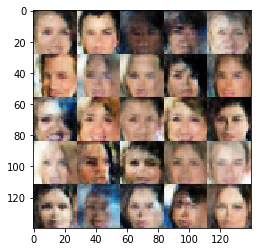

Epoch 2/2; Discriminator Loss: 1.3815; Generator Loss: 0.9006
Epoch 2/2; Discriminator Loss: 1.4229; Generator Loss: 0.7293
Epoch 2/2; Discriminator Loss: 1.2777; Generator Loss: 0.9308
Epoch 2/2; Discriminator Loss: 1.4169; Generator Loss: 0.8783
Epoch 2/2; Discriminator Loss: 1.2824; Generator Loss: 0.8329
Epoch 2/2; Discriminator Loss: 1.4657; Generator Loss: 0.7160
Epoch 2/2; Discriminator Loss: 1.3177; Generator Loss: 0.8218
Epoch 2/2; Discriminator Loss: 1.3528; Generator Loss: 0.8195
Epoch 2/2; Discriminator Loss: 1.4063; Generator Loss: 0.8068
Epoch 2/2; Discriminator Loss: 1.3343; Generator Loss: 0.8455


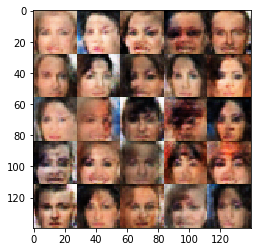

Epoch 2/2; Discriminator Loss: 1.3266; Generator Loss: 0.8307
Epoch 2/2; Discriminator Loss: 1.3339; Generator Loss: 0.8419
Epoch 2/2; Discriminator Loss: 1.3491; Generator Loss: 0.8287
Epoch 2/2; Discriminator Loss: 1.3598; Generator Loss: 0.7954
Epoch 2/2; Discriminator Loss: 1.3585; Generator Loss: 0.9396
Epoch 2/2; Discriminator Loss: 1.3739; Generator Loss: 0.8067
Epoch 2/2; Discriminator Loss: 1.3207; Generator Loss: 0.9347
Epoch 2/2; Discriminator Loss: 1.3813; Generator Loss: 0.7611
Epoch 2/2; Discriminator Loss: 1.4295; Generator Loss: 0.8288
Epoch 2/2; Discriminator Loss: 1.3548; Generator Loss: 0.8497


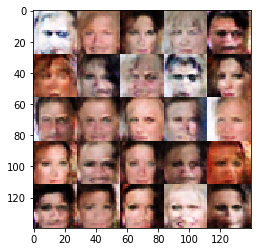

Epoch 2/2; Discriminator Loss: 1.3051; Generator Loss: 0.9015
Epoch 2/2; Discriminator Loss: 1.2964; Generator Loss: 0.8550
Epoch 2/2; Discriminator Loss: 1.3993; Generator Loss: 0.8545
Epoch 2/2; Discriminator Loss: 1.3246; Generator Loss: 0.9063
Epoch 2/2; Discriminator Loss: 1.3393; Generator Loss: 0.7917
Epoch 2/2; Discriminator Loss: 1.3181; Generator Loss: 0.8349
Epoch 2/2; Discriminator Loss: 1.3314; Generator Loss: 0.8834
Epoch 2/2; Discriminator Loss: 1.3976; Generator Loss: 0.8446
Epoch 2/2; Discriminator Loss: 1.2554; Generator Loss: 0.8641
Epoch 2/2; Discriminator Loss: 1.2563; Generator Loss: 0.8698


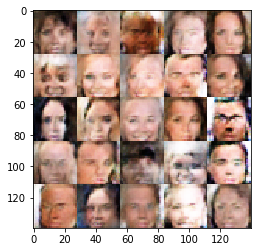

Epoch 2/2; Discriminator Loss: 1.3883; Generator Loss: 0.8106
Epoch 2/2; Discriminator Loss: 1.4039; Generator Loss: 0.8195
Epoch 2/2; Discriminator Loss: 1.2636; Generator Loss: 0.8806
Epoch 2/2; Discriminator Loss: 1.3341; Generator Loss: 0.8308
Epoch 2/2; Discriminator Loss: 1.4171; Generator Loss: 0.8929
Epoch 2/2; Discriminator Loss: 1.4855; Generator Loss: 0.7628
Epoch 2/2; Discriminator Loss: 1.3238; Generator Loss: 0.8072
Epoch 2/2; Discriminator Loss: 1.2330; Generator Loss: 0.9600
Epoch 2/2; Discriminator Loss: 1.3035; Generator Loss: 0.9784
Epoch 2/2; Discriminator Loss: 1.4049; Generator Loss: 0.8075


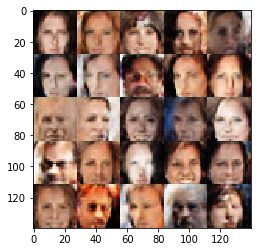

Epoch 2/2; Discriminator Loss: 1.4030; Generator Loss: 0.8065
Epoch 2/2; Discriminator Loss: 1.2972; Generator Loss: 0.8699
Epoch 2/2; Discriminator Loss: 1.3517; Generator Loss: 0.8701
Epoch 2/2; Discriminator Loss: 1.3109; Generator Loss: 0.8843
Epoch 2/2; Discriminator Loss: 1.3314; Generator Loss: 0.8958
Epoch 2/2; Discriminator Loss: 1.3896; Generator Loss: 0.8321
Epoch 2/2; Discriminator Loss: 1.2484; Generator Loss: 0.8630
Epoch 2/2; Discriminator Loss: 1.3739; Generator Loss: 0.7385
Epoch 2/2; Discriminator Loss: 1.3402; Generator Loss: 0.8717
Epoch 2/2; Discriminator Loss: 1.3212; Generator Loss: 0.8466


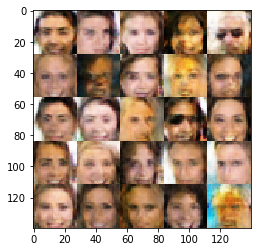

Epoch 2/2; Discriminator Loss: 1.2253; Generator Loss: 0.9448
Epoch 2/2; Discriminator Loss: 1.2797; Generator Loss: 0.8405
Epoch 2/2; Discriminator Loss: 1.3073; Generator Loss: 0.8808
Epoch 2/2; Discriminator Loss: 1.3554; Generator Loss: 0.8324
Epoch 2/2; Discriminator Loss: 1.3199; Generator Loss: 0.8273
Epoch 2/2; Discriminator Loss: 1.3129; Generator Loss: 0.8197
Epoch 2/2; Discriminator Loss: 1.3397; Generator Loss: 0.8604
Epoch 2/2; Discriminator Loss: 1.3059; Generator Loss: 0.8262
Epoch 2/2; Discriminator Loss: 1.3113; Generator Loss: 0.8529
Epoch 2/2; Discriminator Loss: 1.3662; Generator Loss: 0.8290


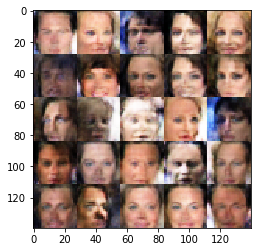

Epoch 2/2; Discriminator Loss: 1.3567; Generator Loss: 0.8226
Epoch 2/2; Discriminator Loss: 1.3880; Generator Loss: 0.7920
Epoch 2/2; Discriminator Loss: 1.3900; Generator Loss: 0.7928
Epoch 2/2; Discriminator Loss: 1.2904; Generator Loss: 0.9298
Epoch 2/2; Discriminator Loss: 1.3831; Generator Loss: 0.8824
Epoch 2/2; Discriminator Loss: 1.2264; Generator Loss: 0.8681
Epoch 2/2; Discriminator Loss: 1.2913; Generator Loss: 0.8917
Epoch 2/2; Discriminator Loss: 1.5729; Generator Loss: 0.6803
Epoch 2/2; Discriminator Loss: 1.3219; Generator Loss: 0.8584
Epoch 2/2; Discriminator Loss: 1.2746; Generator Loss: 0.8641


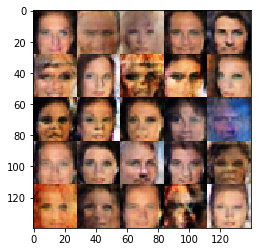

Epoch 2/2; Discriminator Loss: 1.3402; Generator Loss: 0.8597
Epoch 2/2; Discriminator Loss: 1.3848; Generator Loss: 0.7839
Epoch 2/2; Discriminator Loss: 1.2144; Generator Loss: 0.8182
Epoch 2/2; Discriminator Loss: 1.3461; Generator Loss: 0.7603
Epoch 2/2; Discriminator Loss: 1.3078; Generator Loss: 0.9107
Epoch 2/2; Discriminator Loss: 1.4359; Generator Loss: 0.7861
Epoch 2/2; Discriminator Loss: 1.2976; Generator Loss: 0.8363
Epoch 2/2; Discriminator Loss: 1.3314; Generator Loss: 0.8332
Epoch 2/2; Discriminator Loss: 1.2549; Generator Loss: 0.9241
Epoch 2/2; Discriminator Loss: 1.2824; Generator Loss: 0.8711


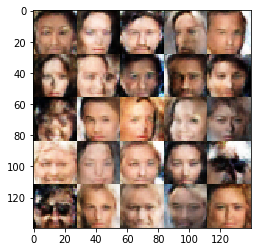

Epoch 2/2; Discriminator Loss: 1.3011; Generator Loss: 0.9794
Epoch 2/2; Discriminator Loss: 1.2786; Generator Loss: 0.8896
Epoch 2/2; Discriminator Loss: 1.3200; Generator Loss: 0.8916
Epoch 2/2; Discriminator Loss: 1.2321; Generator Loss: 0.9604
Epoch 2/2; Discriminator Loss: 1.2848; Generator Loss: 0.9019
Epoch 2/2; Discriminator Loss: 1.3595; Generator Loss: 0.8216
Epoch 2/2; Discriminator Loss: 1.3594; Generator Loss: 0.8284
Epoch 2/2; Discriminator Loss: 1.2843; Generator Loss: 0.8078
Epoch 2/2; Discriminator Loss: 1.4062; Generator Loss: 0.7556
Epoch 2/2; Discriminator Loss: 1.4067; Generator Loss: 0.8525


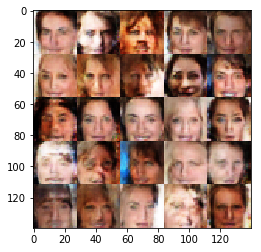

Epoch 2/2; Discriminator Loss: 1.4400; Generator Loss: 0.7666
Epoch 2/2; Discriminator Loss: 1.2329; Generator Loss: 0.9490
Epoch 2/2; Discriminator Loss: 1.3211; Generator Loss: 0.8341
Epoch 2/2; Discriminator Loss: 1.3693; Generator Loss: 0.8592
Epoch 2/2; Discriminator Loss: 1.2845; Generator Loss: 0.8856
Epoch 2/2; Discriminator Loss: 1.2797; Generator Loss: 0.9001
Epoch 2/2; Discriminator Loss: 1.3615; Generator Loss: 0.8329
Epoch 2/2; Discriminator Loss: 1.3211; Generator Loss: 0.8284
Epoch 2/2; Discriminator Loss: 1.3153; Generator Loss: 0.8634
Epoch 2/2; Discriminator Loss: 1.3783; Generator Loss: 0.7500


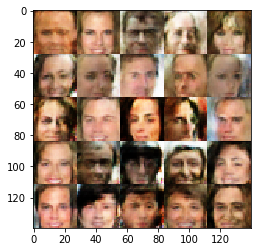

Epoch 2/2; Discriminator Loss: 1.2652; Generator Loss: 0.8465
Epoch 2/2; Discriminator Loss: 1.3603; Generator Loss: 0.8167
Epoch 2/2; Discriminator Loss: 1.3957; Generator Loss: 0.7802
Epoch 2/2; Discriminator Loss: 1.3384; Generator Loss: 0.7587
Epoch 2/2; Discriminator Loss: 1.3019; Generator Loss: 0.8414
Epoch 2/2; Discriminator Loss: 1.3388; Generator Loss: 0.8959
Epoch 2/2; Discriminator Loss: 1.3211; Generator Loss: 0.8053
Epoch 2/2; Discriminator Loss: 1.2168; Generator Loss: 0.9210
Epoch 2/2; Discriminator Loss: 1.3325; Generator Loss: 0.8563
Epoch 2/2; Discriminator Loss: 1.3011; Generator Loss: 0.8008


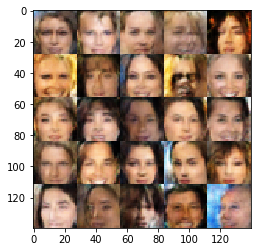

Epoch 2/2; Discriminator Loss: 1.2817; Generator Loss: 0.8887
Epoch 2/2; Discriminator Loss: 1.3616; Generator Loss: 0.8305
Epoch 2/2; Discriminator Loss: 1.4122; Generator Loss: 0.7585
Epoch 2/2; Discriminator Loss: 1.2799; Generator Loss: 0.9362
Epoch 2/2; Discriminator Loss: 1.2744; Generator Loss: 0.9002
Epoch 2/2; Discriminator Loss: 1.3957; Generator Loss: 0.7820


In [46]:
batch_size  = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.